# OSMF 2021 Contributor Survey Analysis

For the time period of the survey (January - February 2021), where have contributors been editing OSM, in relation to where they may live (by Country).

### How do we determine which Country a mapper might be from?
There has been a decent amount of research on this question, and it's a moving target. One reasonable thought (if we ignore humanitarian or paid-editing teams), is that the Country in which a mapper makes the majority of their changesets is perhaps their home. If not their _actual home_, it is still clearly a location they posess knowledge of and continually map. Some of Pascal Neis's tools use this approach, so I will re-create it here roughly. 

Quick & Dirty: Group all of a users changesets from the last five years together based on the rounded value of the min lon/lat from the changeset metadata. If the corner of a changeset bounding box is (11.272132, 23.838870), it becomes (11,24). Make a list of these rounded coordinates and take the MODE (most commonly occuring). Now see which Country that point falls within.

<hr>

_Note, as of February 12, the most recent data available on the AWS public dataset is is 2/08/2021, so this is not the entire editing window of the survey. This approach should, however, continue to work as we get more changesets._

Thanks!

[Jennings Anderson](https://jenningsanderson.com)

In [15]:
import pandas as pd; import geopandas as gpd; import seaborn as sns
from shapely.geometry import Point;
import fiona, sys, json;
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,filename,geometry
0,1,Admin-0 country,6,Belize,BLZ,0,2,Sovereign country,Belize,BLZ,...,Americas,Central America,Latin America & Caribbean,6,6,6,-99,1,BLZ.geojson,"POLYGON ((-89.14308 17.80832, -89.15091 17.955..."
1,1,Admin-0 country,4,The Bahamas,BHS,0,2,Sovereign country,The Bahamas,BHS,...,Americas,Caribbean,Latin America & Caribbean,7,7,4,-99,1,BHS.geojson,"MULTIPOLYGON (((-77.53466 23.75975, -77.78000 ..."
2,1,Admin-0 country,5,Costa Rica,CRI,0,2,Sovereign country,Costa Rica,CRI,...,Americas,Central America,Latin America & Caribbean,10,10,4,-99,1,CRI.geojson,"POLYGON ((-82.96578 8.22503, -83.50844 8.44693..."


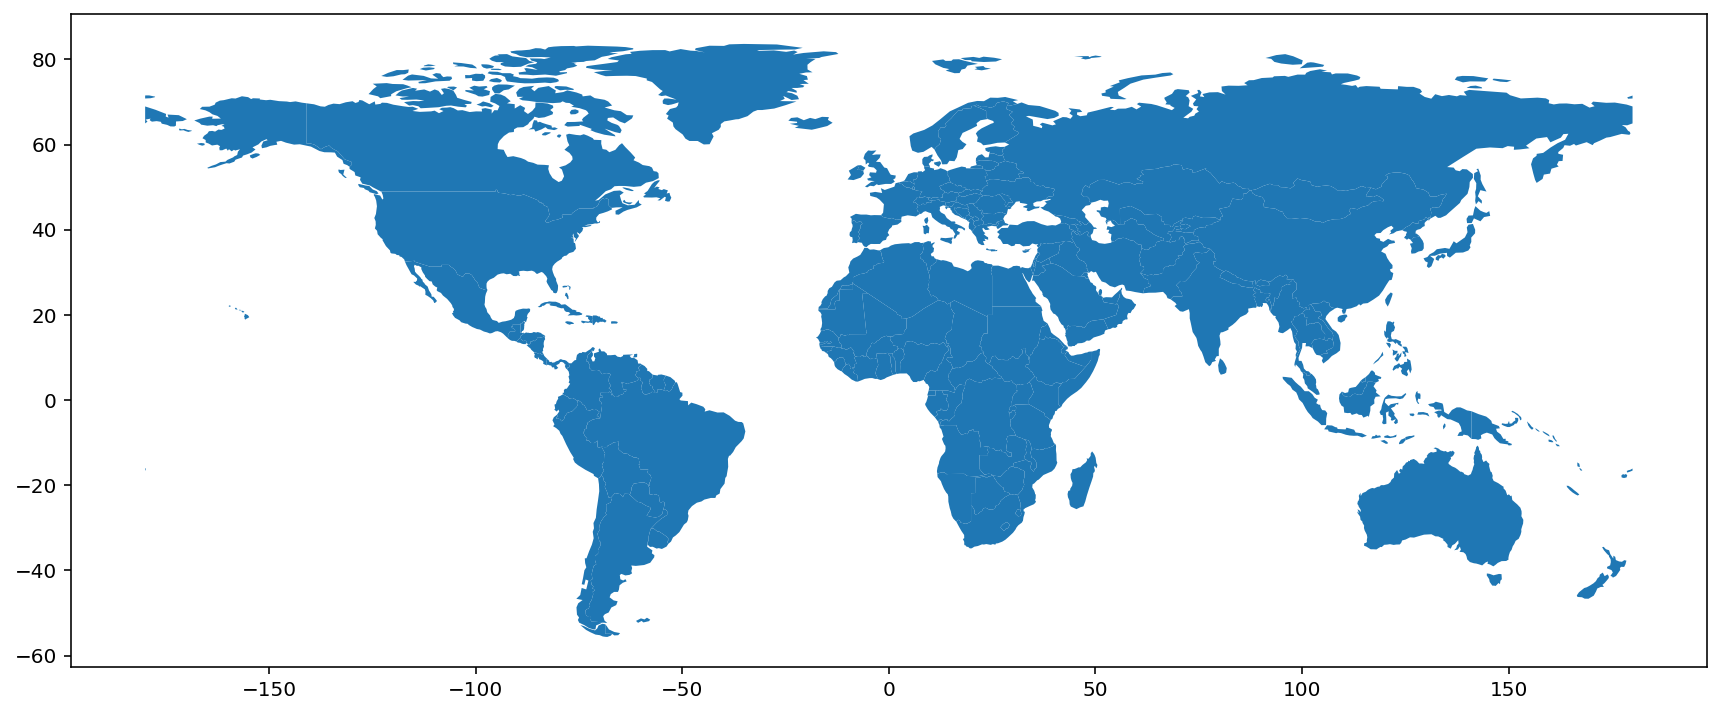

In [16]:
#First, read in a file that has Country Boundaries
countries = gpd.read_file('./data/world.geojson') #175 Countries, not perfect.
countries.plot(figsize=(16,6))
countries.head(3)

# Query:

Extract our data from the OSM Changesets data on AWS:

```sql
-- First, where does a user edit most in the last 5 years?

WITH most_frequent_editing_location AS (
  WITH rounded_coords as (
    SELECT 
      uid, 
      ARRAY[round(min_lon), round(min_lat)] AS _coords
    FROM
      changesets
    WHERE ("created_at" >= ((SELECT "max"("created_at")
                             FROM changesets) - INTERVAL  '5' YEAR))
  )
  SELECT uid, _coords AS frequent_editing_location
  FROM (SELECT uid, _coords, COUNT(*) AS cnt,
        ROW_NUMBER() OVER (PARTITION BY uid ORDER BY COUNT(*) DESC) AS seqnum
    FROM rounded_coords
    GROUP BY uid, _coords
  ) t
  WHERE seqnum = 1
), 
-- Second, who are the current active contributors?
active_contributor as (
  SELECT
    uid,
    COUNT(id) as changesets_in_last365,
    COUNT(DISTINCT(date_trunc('day', created_at))) AS editing_days_in_last365,
    SUM(num_changes) AS total_edits_in_last365,
    MAX(created_at) AS most_recent_changeset
  FROM
    changesets
  WHERE (created_at >= ((SELECT MAX(created_at) FROM changesets) - INTERVAL  '365' DAY))
  GROUP BY uid
)
-- Now join it all together
SELECT 
  id, changesets.uid, "user", min_lon, min_lat, editing_days_in_last365, frequent_editing_location
FROM changesets
LEFT JOIN active_contributors ON changesets.uid = active_contributors.uid
LEFT JOIN most_frequent_editing_location ON most_frequent_editing_location.uid = changesets.uid
WHERE created_at >= date '2021-1-16' AND created_at <= date '2021-2-14' 
```

Save this file as `OSM_changesets.csv`

In [17]:
#Now read in the changesets file, output from this query: 
changesets = pd.read_csv('./data/OSM_changesets.csv')
changesets['geometry'] = changesets.apply(lambda row: Point(row.min_lon, row.min_lat), axis=1)
changesets = gpd.GeoDataFrame(changesets)
changesets['country'] = None

In [149]:
print("Read in {:,} changesets".format(len(changesets)))
print("First Changeset: https://openstreetmap.org/changeset/{}\nLatest Changeset: https://openstreetmap.org/changeset/{}".format(changesets.id.min(), changesets.id.max()))

Read in 1,283,286 changesets
First Changeset: https://openstreetmap.org/changeset/97586992
Latest Changeset: https://openstreetmap.org/changeset/98870277


In [19]:
# We want to find a "home country" for each user
homes = pd.DataFrame(changesets[['uid','frequent_editing_location']].drop_duplicates('uid', keep='first'))
homes.frequent_editing_location = homes.frequent_editing_location.apply(lambda c: 
                                                                        ( json.loads(c)[0], json.loads(c)[1]))
# There are a handful of mappers that error out here, not sure why? (maybe 70?)
homes['geometry'] = homes.frequent_editing_location.apply(lambda t: Point(t) if t[0]!=None else None)
homes = gpd.GeoDataFrame(homes[~pd.isna(homes.geometry)]).set_crs(epsg=4326)
print("Found {:,} mappers".format(len(homes)))
homes.head(2)

Found 42,528 mappers


,uid,frequent_editing_location,geometry
0,1886646,"(92, 21)",POINT (92.00000 21.00000)
2,9545352,"(21, 41)",POINT (21.00000 41.00000)


In [20]:
#Iterate through all of the Countries and label changesets with a Country name
user_homes = []

for idx, country in countries.iterrows(): 
    # Works best with a buffer for those who edit on the coast / inlets
    this_geom_buffered = country.geometry.buffer(0.1) 
    users_from_here = homes[homes.geometry.within(this_geom_buffered)]
    edits_in_here   = changesets[changesets.geometry.within(this_geom_buffered)]

    if len(users_from_here):
        for uid in users_from_here.uid:
            user_homes.append({
                'uid':uid,
                'home_country':country.admin,
                'home_country_geom': country.geometry
            })
    
    if len(edits_in_here):
        changesets.loc[edits_in_here.index,'country'] = country.admin
        
    sys.stderr.write("\r{:,} countries processed    ".format(idx+1))

175 countries processed    

In [150]:
print("Overall, identified potential (likely?) home countries for {:,} mappers".format(len(user_homes)))

Overall, identified potential (likely?) home countries for 41,827 mappers


In [22]:
df = changesets.merge(pd.DataFrame(user_homes), on='uid')
df['is_local'] = df.home_country == df.country
df.head(2)

,id,uid,user,min_lon,min_lat,editing_days_in_last365,frequent_editing_location,geometry,country,home_country,home_country_geom,is_local
0,98806092,9545352,RUS_SCN,21.313038,41.025637,226,"[21, 41]",POINT (21.31304 41.02564),Macedonia,Macedonia,"POLYGON ((20.59023 41.85541, 20.71731000000011...",True
1,98806094,9545352,RUS_SCN,21.312272,41.023636,226,"[21, 41]",POINT (21.31227 41.02364),Macedonia,Macedonia,"POLYGON ((20.59023 41.85541, 20.71731000000011...",True


# Aggregate Per Country

Counts the number of Changesets submitted per Country — as in, the Country that the changeset falls within. In this case, "local" refers to whether or not the mapper who submitted each changeset is _likely_ from that Country.

Countries like the USA are going to be over-inflated with "local" changesets because of mapping teams like Amazon Logistics that almost exclusively edit in the US, and with huge volume. 

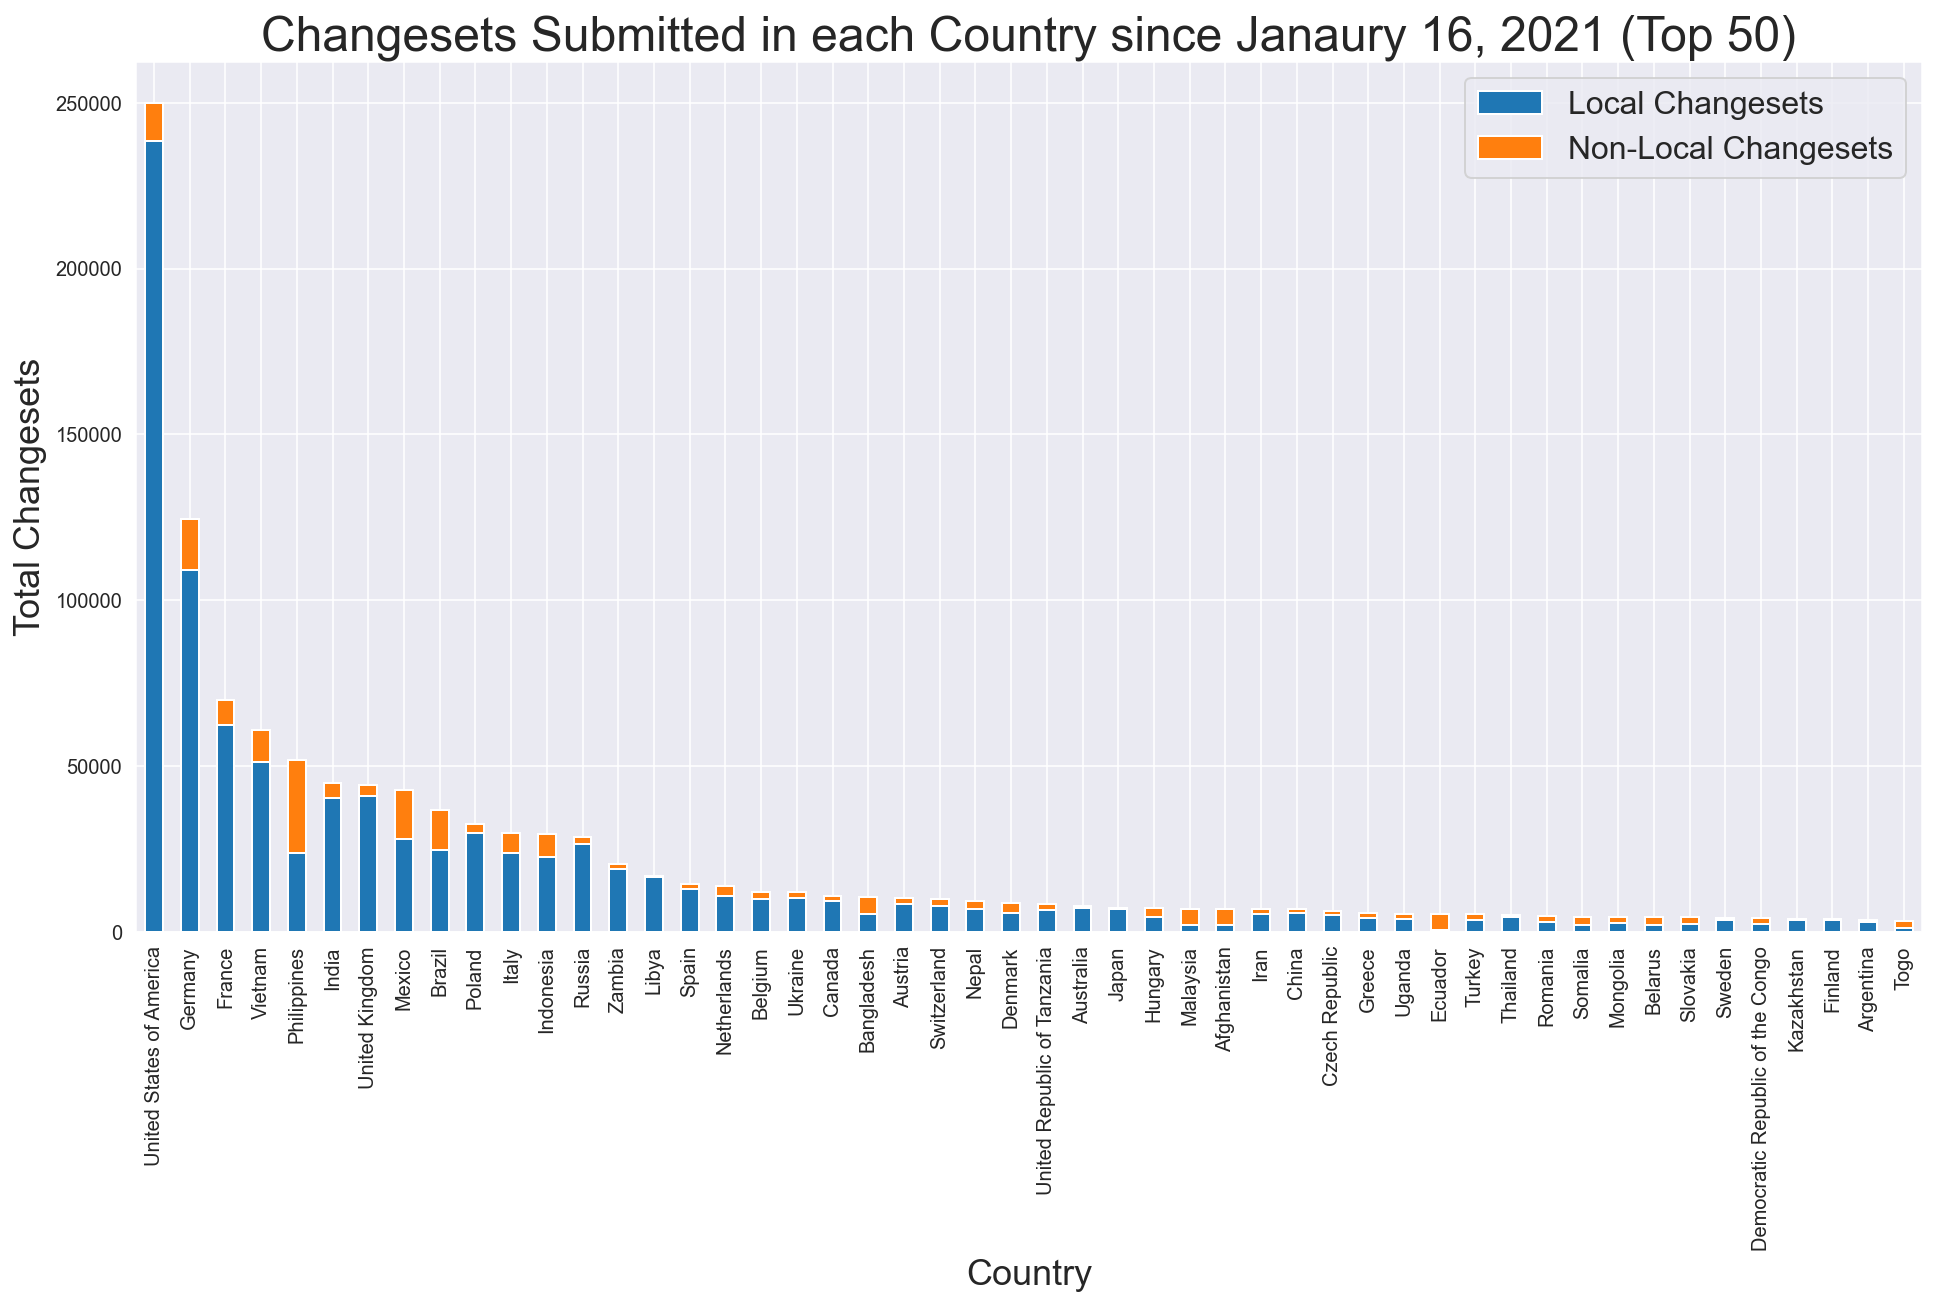

In [87]:
sns.set_style('darkgrid')
gb_country = df.groupby('country').aggregate({'uid':pd.Series.nunique,'user':'count','is_local':sum})
gb_country['non_local'] = gb_country.user - gb_country.is_local
gb_country = gb_country.rename(columns={'is_local':'Local Changesets','non_local':'Non-Local Changesets','uid':'Total Users','user':'Total Changesets'})
ax = gb_country.sort_values(by='Total Changesets', ascending=False).head(50)[['Local Changesets','Non-Local Changesets']].plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Country", fontsize=18); ax.set_ylabel("Total Changesets", fontsize=18);
ax.set_title("Changesets Submitted in each Country since Janaury 16, 2021 (Top 50)", fontsize=24);
ax.legend(fontsize=16);

# Aggregated by Mapper

Breaking down the "Total Mappers" count by local/non-local per Country

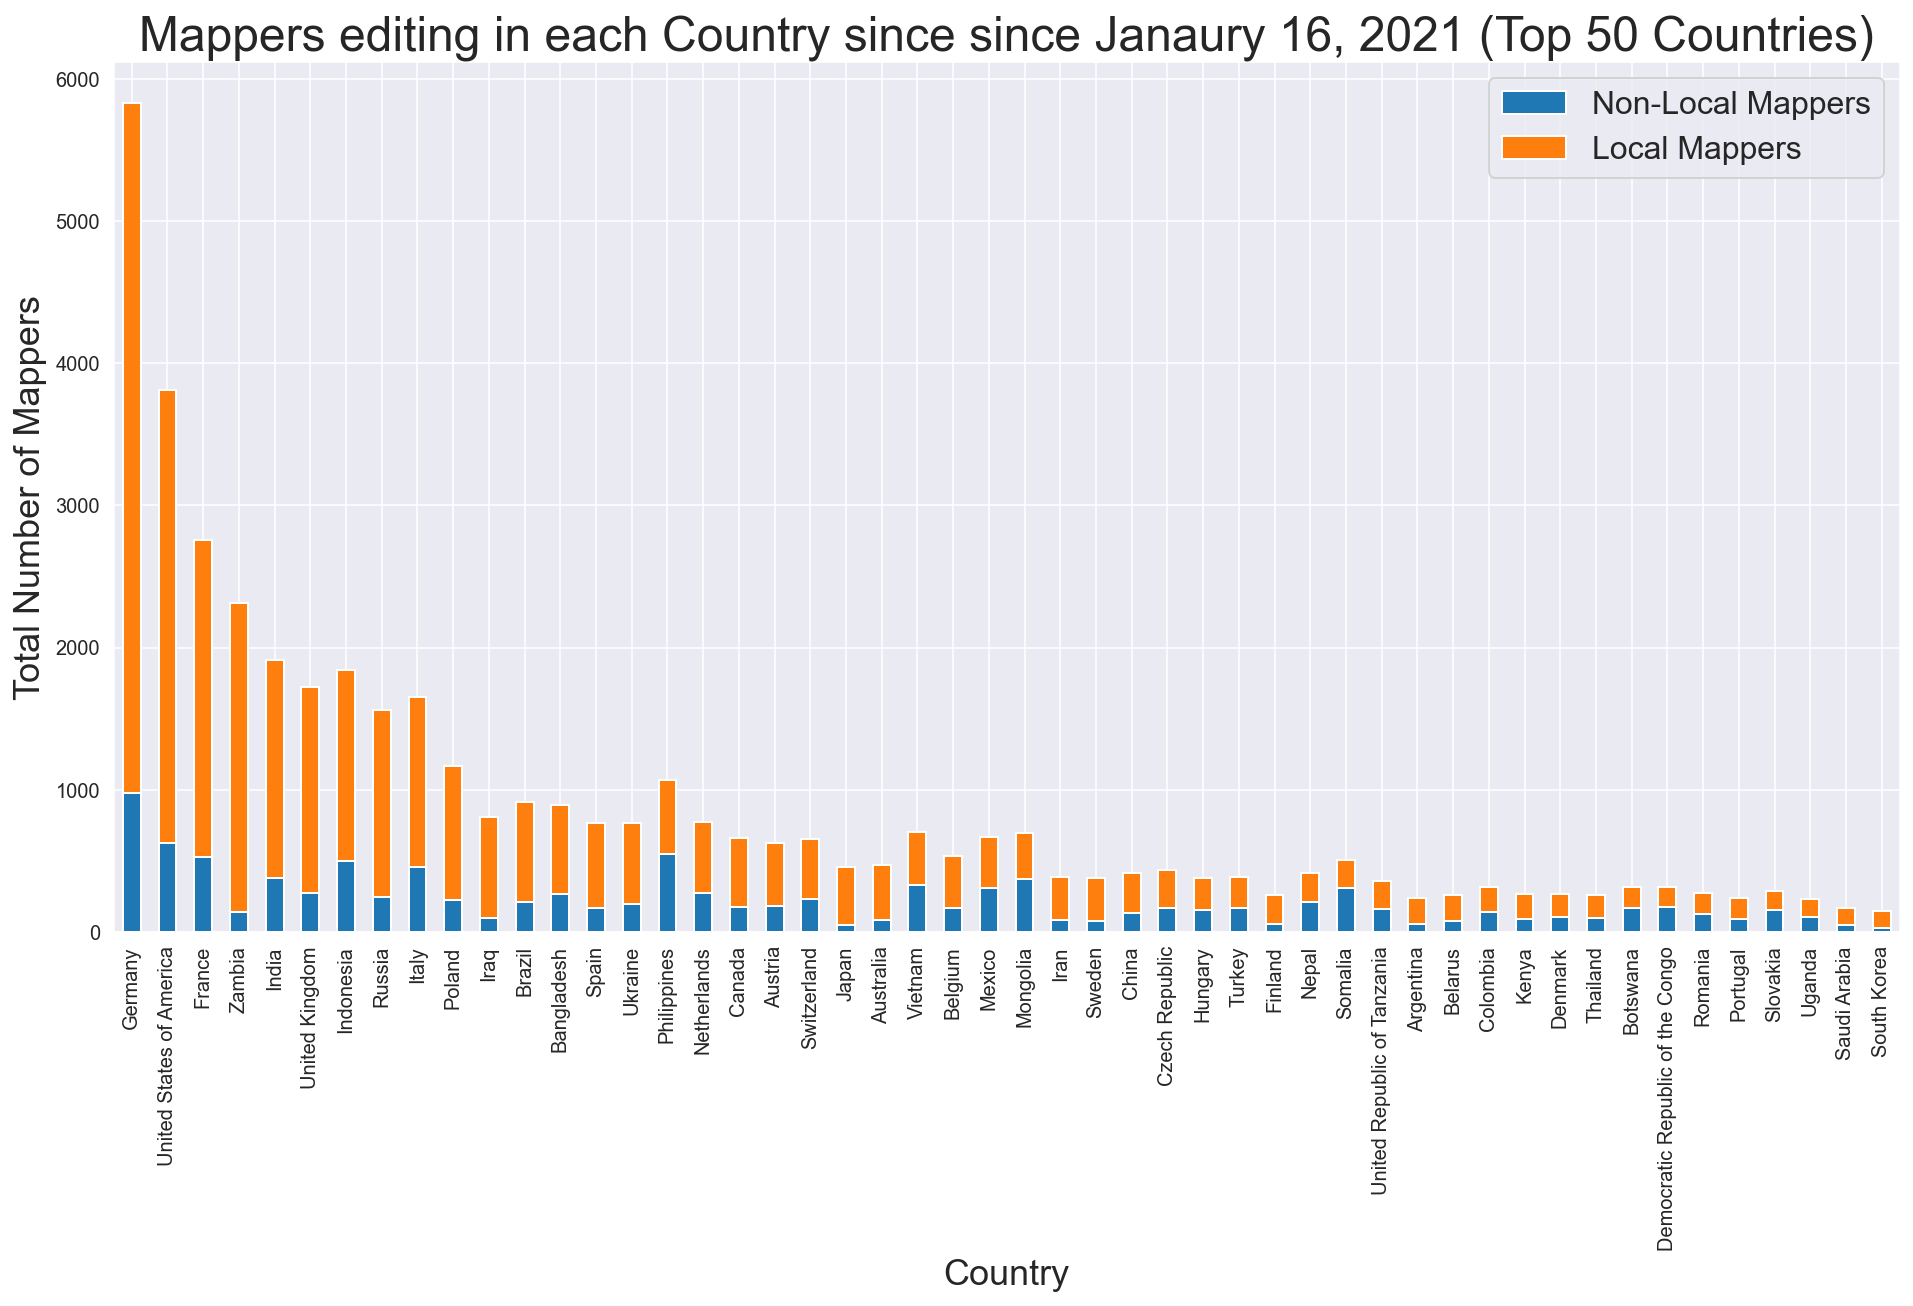

In [117]:
sns.set_style('darkgrid')
gb_country_local = df.groupby(['country','is_local']).aggregate({'uid':pd.Series.nunique}).unstack()
gb_country_local.columns = gb_country_local.columns.droplevel()
gb_country_local = gb_country_local.rename(columns={ False:"Non-Local Mappers",True:"Local Mappers"})
gb_country_local = gb_country_local.rename(columns={('country', False):"Non-Local Mappers",('country', True):"Local Mappers"})
ax = gb_country_local.sort_values(by='Local Mappers', ascending=False).head(50).plot.bar(stacked=True, figsize=(16,8))
ax.set_xlabel("Country", fontsize=18); ax.set_ylabel("Total Number of Mappers", fontsize=18);
ax.set_title("Mappers editing in each Country since since Janaury 16, 2021 (Top 50 Countries)", fontsize=24);
ax.legend(fontsize=16);

# Identifying the _Active Contributors_ active per Country?

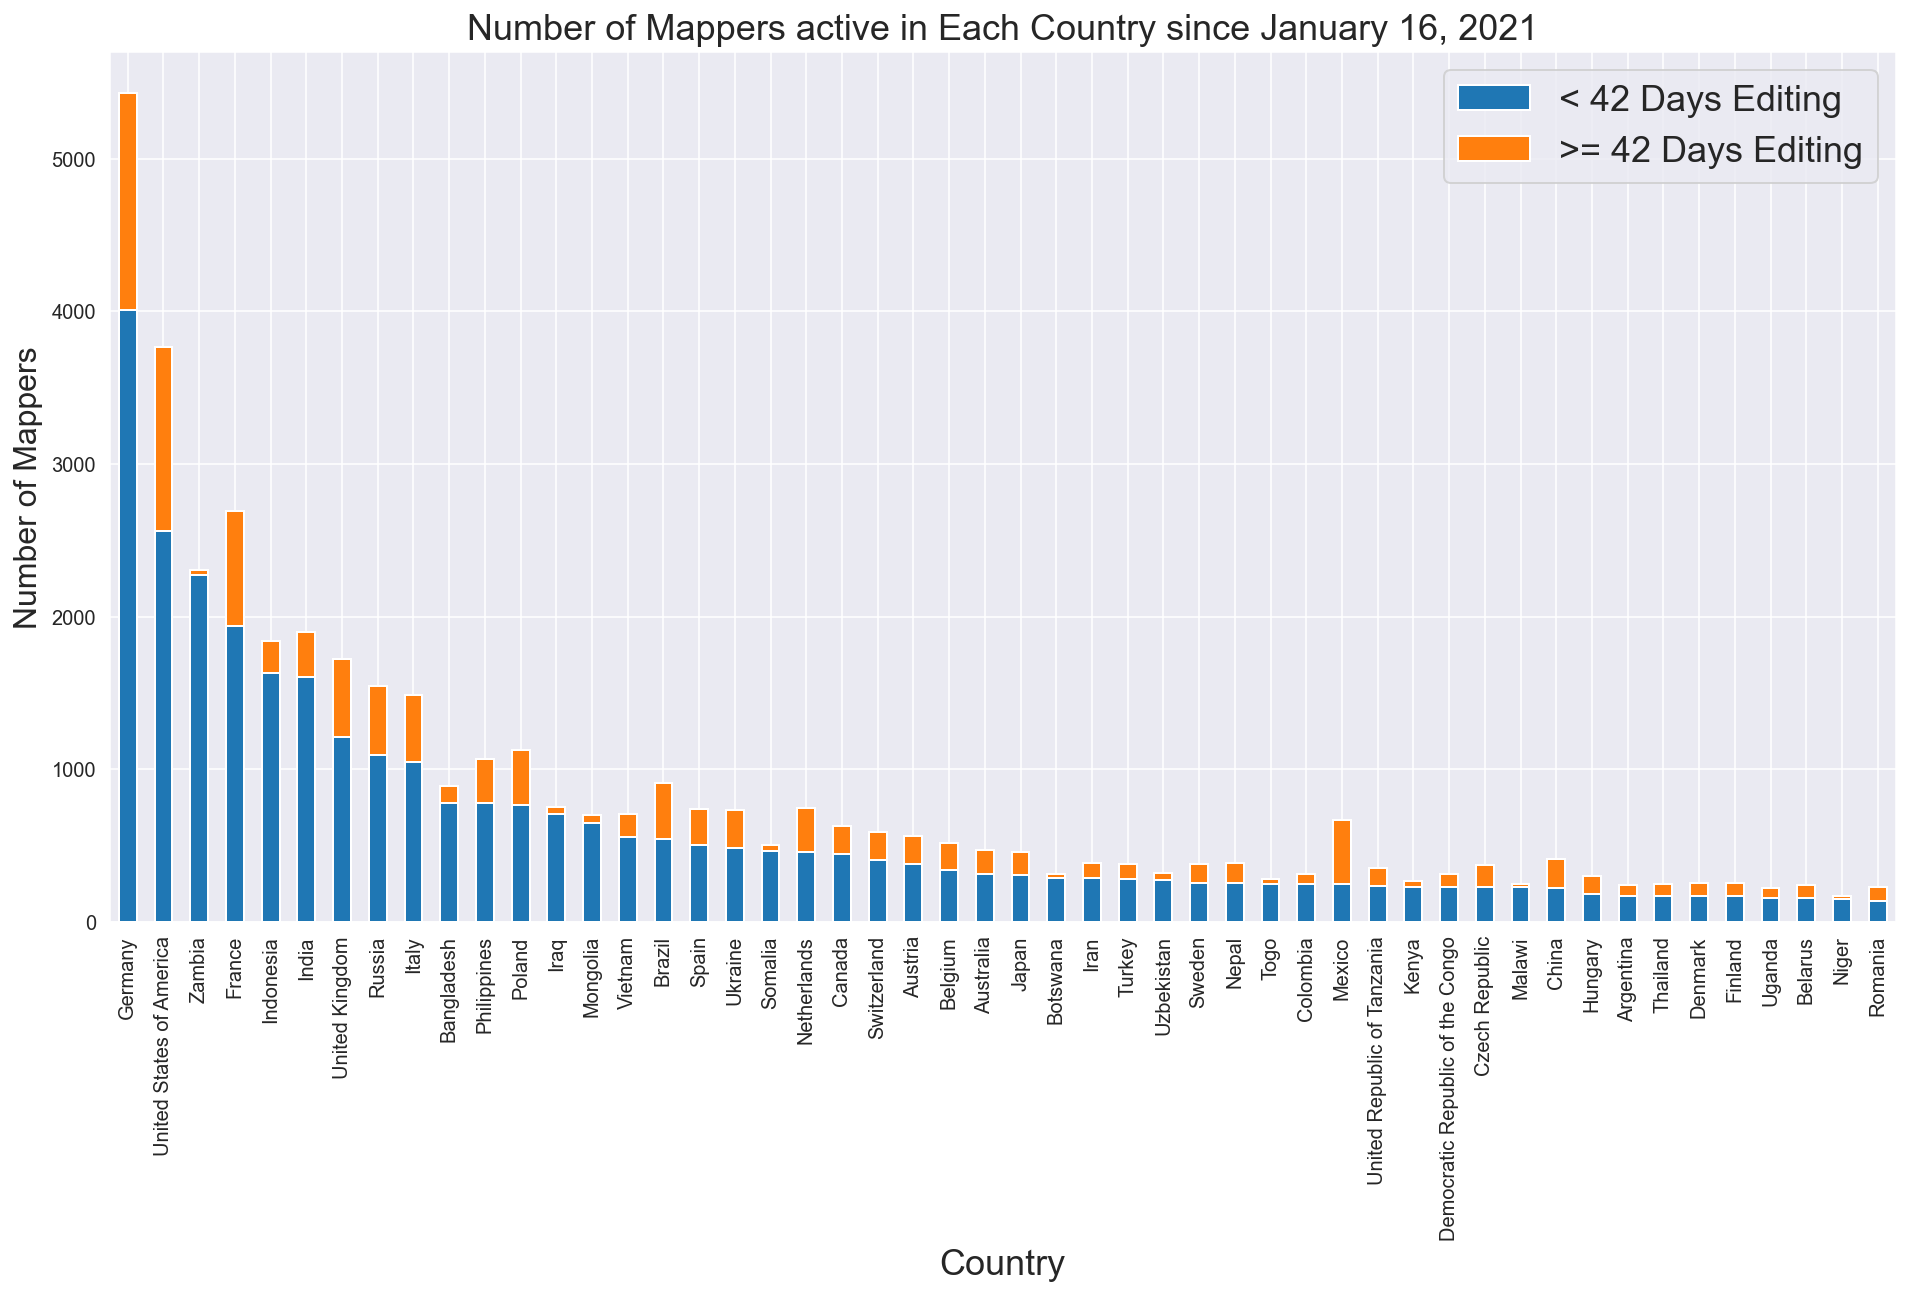

In [138]:
df['is_active_contributor'] = df.editing_days_in_last365 > 41
gb_country_active = df.groupby(['country','is_active_contributor']).aggregate({'uid':pd.Series.nunique}).unstack()
gb_country_active.columns = gb_country_active.columns.droplevel()
gb_country_active = gb_country_active.rename(columns={ False:"< 42 Days Editing",True:">= 42 Days Editing"})
ax = gb_country_active.sort_values(by="< 42 Days Editing",ascending=False).head(50).plot.bar(stacked=True, figsize=(16,8));
ax.legend(fontsize=18)
ax.set_ylabel("Number of Mappers", fontsize=16); ax.set_xlabel("Country", fontsize=18);
ax.set_title("Number of Mappers active in Each Country since January 16, 2021", fontsize=18);

In [139]:
as_table = gb_country_local.join(gb_country).join(gb_country_active)
as_table

,Non-Local Mappers,Local Mappers,Total Users,Total Changesets,Local Changesets,Non-Local Changesets,< 42 Days Editing,>= 42 Days Editing
country,,,,,,,,
Afghanistan,45.0,22.0,61,6777,1933,4844,21.0,40.0
Albania,28.0,12.0,40,141,58,83,17.0,23.0
Algeria,26.0,75.0,100,2291,2207,84,80.0,20.0
Angola,22.0,11.0,33,415,275,140,19.0,14.0
Argentina,53.0,186.0,239,3510,3052,458,167.0,72.0
...,...,...,...,...,...,...,...,...
Vietnam,328.0,376.0,703,60711,51046,9665,558.0,145.0
Western Sahara,2.0,NaN,2,26,0,26,2.0,NaN
Yemen,18.0,37.0,55,378,262,116,42.0,13.0


In [152]:
as_table.to_csv('./data/country_editing_stats_OSMF_survey.csv')